In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime

### Data import

    Assortment - assortment_test.zip
    Описание набора и полей данных: 

    assortment_test.csv - ассортимент двух товарных категорий Brake pad set и Brake disc
    article_id:  id артикула     
    brand_number: номер бренда        
    category_name: имя товарной категории   
    price: цена товара в Евро
    sales_qty: продажи за год, в штуках          
    sales_netto: продажи за год, в ценах себестоимости (в закупочных ценах)       
    sales_revenue: продажи за год, в ценах продажи 
    sales_count_country: кол-во стран в которых продавался товар за год
    all_OEM_number: список OEM номеров, для определения взаимозаменяемости запчастей. 


In [2]:
assortment_test = pd.read_csv('Test_DA_atd_pb/assortment_test/assortment_test.csv')
assortment_test

,article_id,brand_number,category_name,price,sales_qty,sales_netto,sales_revenue,sales_count_country,all_OEM_number
0,1,11385,Brake pad set,37.85,1,23.120001,40.200001,1,"15920117, 15920396"
1,2,11385,Brake pad set,12.57,0,0.000000,0.000000,0,935015
2,3,11385,Brake pad set,8.86,3,15.659999,31.620000,2,"47800849, 15920103, 3221003"
3,4,11893,Brake pad set,29.92,0,0.000000,0.000000,0,"1614412180, 5P1902, 1612434180, 77366679"
4,5,11893,Brake pad set,20.66,2,24.880000,39.220001,2,"4106000Q1L, 410605961R, 8660000781, 410601306R..."
...,...,...,...,...,...,...,...,...,...
269066,269067,4364,Brake disc,38.40,4,94.279999,166.580002,2,4351228190
269067,269068,4364,Brake disc,29.76,0,0.000000,0.000000,0,"4351212710, 4351202300"
269068,269069,4364,Brake disc,12.63,0,0.000000,0.000000,0,4351274010
269069,269070,4364,Brake disc,30.12,0,0.000000,0.000000,0,"4351242031, 4351242030, 4351242032, 4351232250..."


In [3]:
assortment_test.describe().round(2)

,article_id,brand_number,price,sales_qty,sales_netto,sales_revenue,sales_count_country
count,269071.00,269071.00,269071.00,269071.00,269071.00,269071.00,269071.00
mean,134536.00,11436.14,42.26,18.33,277.58,491.41,1.50
std,77674.25,27417.01,67.55,194.04,2267.44,4007.21,3.81
min,1.00,1.00,0.02,-4.00,-522.92,-751.46,0.00
25%,67268.50,86.00,19.16,0.00,0.00,0.00,0.00
50%,134536.00,381.00,28.67,0.00,0.00,0.00,0.00
75%,201803.50,10221.00,45.15,1.00,11.42,20.89,1.00
max,269071.00,101378.00,1909.90,38528.00,157162.22,376959.84,29.00


#### Описательная статистика:
- **article_id**: идентификаторы товаров распределены равномерно, 1-269071 ids
- **brand_number**: есть большой разброс в номерах брендов.
- **price**: средняя цена товара составляет 42.26, но есть значительные отклонения,
    максимальная цена достигает 1909.90.
- **sales_qty**: среднее количество продаж составляет около 18, но стандартное отклонение очень велико, что указывает на значительные различия в количестве продаж между товарами.
- **sales_netto** и **sales_revenue**: здесь также наблюдается большой разброс значений, что указывает на различия в экономическом воздействии различных товаров.
- **sales_count_country**: в среднем, продажи товаров сосредоточены примерно в 1.5 странах.

### Data fix

In [4]:
assortment_test.isna().sum()

article_id                 0
brand_number               0
category_name              0
price                      0
sales_qty                  0
sales_netto                0
sales_revenue              0
sales_count_country        0
all_OEM_number         21689
dtype: int64

In [5]:
assortment_test['all_OEM_number'].astype(str).value_counts().reset_index()

,all_OEM_number,count
0,nan,21689
1,4F0615601E,118
2,"8N0615601B, 8L0615601",104
3,1J0615601D,101
4,8D0615601B,97
...,...,...
85347,"9947629, 9948410, 71752981, 6001073149, 717529...",1
85348,"77362231, 77362344, 77362222, 9950637, 9944678...",1
85349,"9948222, 60765010, 77362186, 71753042, 7175304...",1
85350,"77364517, 77364158, 425496, 77364919, 77364393...",1


In [6]:
# replacing nan to '0' value
assortment_test['all_OEM_number'].fillna('0', inplace=True)

# Проверка на успешность замены
assortment_test.isna().sum()

article_id             0
brand_number           0
category_name          0
price                  0
sales_qty              0
sales_netto            0
sales_revenue          0
sales_count_country    0
all_OEM_number         0
dtype: int64

### Data Visualization

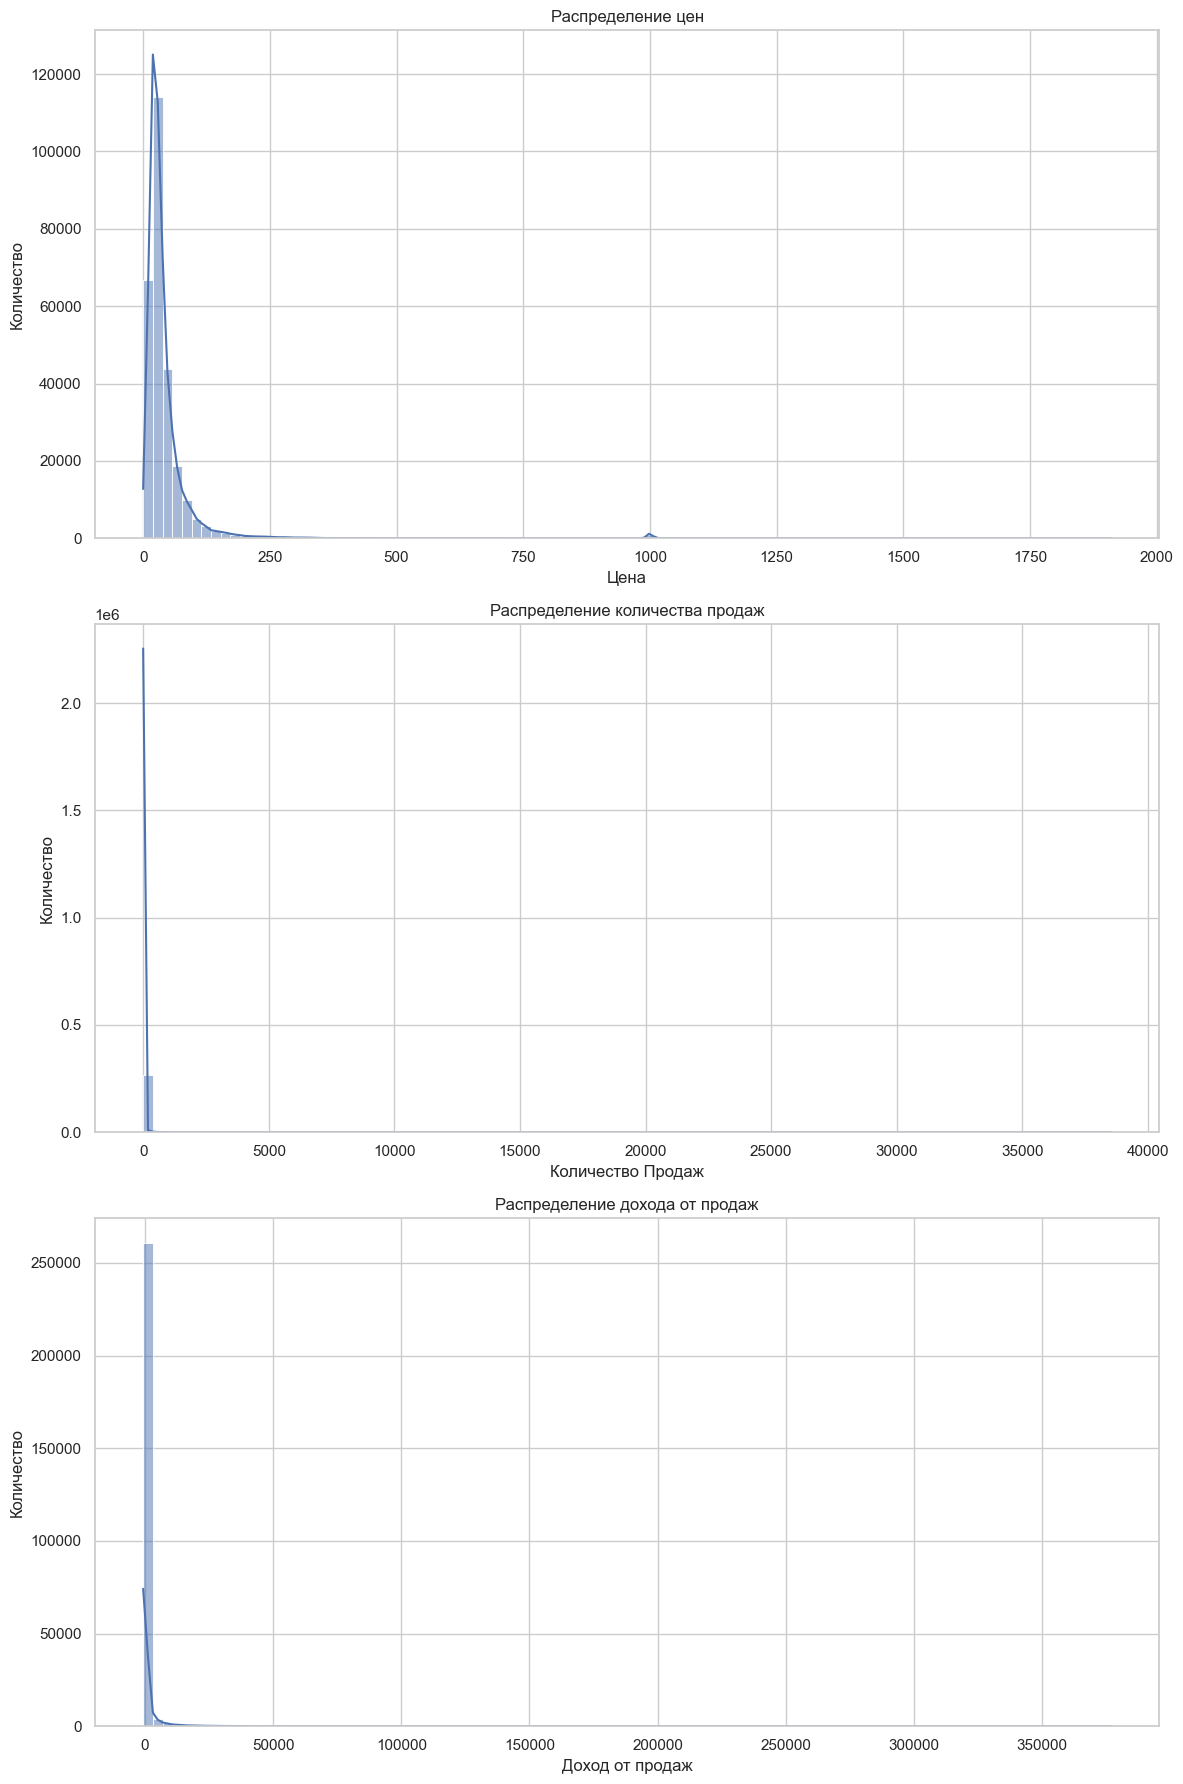

price max: 1909.9
sales quantity max: 38528
sales revenue max: 376959.83739233


In [50]:
# настройка стиля графиков
sns.set(style="whitegrid")

# визуализация распределения ключевых переменных
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# bar chart цены
sns.histplot(assortment_test['price'], bins=100, kde=True, ax=axes[0])
axes[0].set_title('Распределение цен')
axes[0].set_xlabel('Цена')
axes[0].set_ylabel('Количество')

# bar chart количества продаж
sns.histplot(assortment_test['sales_qty'], bins=100, kde=True, ax=axes[1])
axes[1].set_title('Распределение количества продаж')
axes[1].set_xlabel('Количество Продаж')
axes[1].set_ylabel('Количество')

# bar chart дохода от продаж
sns.histplot(assortment_test['sales_revenue'], bins=100, kde=True, ax=axes[2])
axes[2].set_title('Распределение дохода от продаж')
axes[2].set_xlabel('Доход от продаж')
axes[2].set_ylabel('Количество')

plt.tight_layout()
plt.show()

print('price max:', max(assortment_test['price'].tolist())) # цена
print('sales quantity max:', max(assortment_test['sales_qty'].tolist())) # количество продаж
print('sales revenue max:', max(assortment_test['sales_revenue'].tolist())) # доход от продаж

- Распределение Цен:
 - Большинство товаров имеют цену ниже 100, с наибольшей концентрацией в диапазоне от 0 до 50.
 - Распределение имеет тяжелый правый хвост, что указывает на наличие относительно немногих товаров с очень высокими ценами.


- Распределение Количества Продаж:
 - Большая часть товаров имеет низкие объемы продаж, что видно из сосредоточения данных близко к 0.
 - Распределение также скошено вправо, с некоторыми товарами, имеющими значительно большие объемы продаж.


- Распределение Дохода от Продаж:
 - Похоже на распределение количества продаж, большая часть товаров имеет низкий доход от продаж.
 - Также существует ряд товаров с высоким доходом, что видно из длинного хвоста распределения.

### Correlation analysis

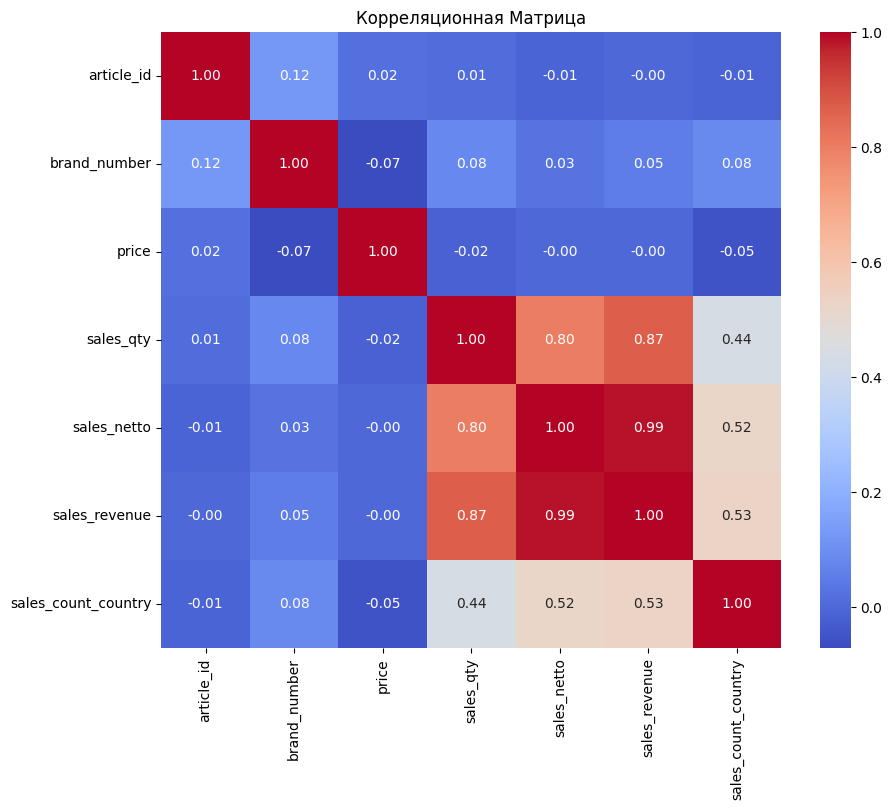

In [7]:
correlation_matrix = assortment_test.select_dtypes(include=['float64', 'int64']).corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная Матрица')
plt.show()

 - Существует умеренная положительная корреляция между **sales_qty**(количество продаж) и **sales_netto**(чистая сумма продаж), а также между **sales_qty** и **sales_revenue**(доход от продаж). Это ожидаемо, так как большее количество продаж обычно приводит к большему доходу.
 
 - **price**(цена) слабо коррелирует с другими переменными продаж, что может указывать на то, что цена не является единственным фактором, влияющим на количество продаж или доход.

 - **sales_count_country**(количество продаж в стране) также имеет умеренную корреляцию с sales_qty, sales_netto и sales_revenue, что говорит о том, что распределение продаж по странам влияет на общие показатели продаж.

### Двумерный анализ

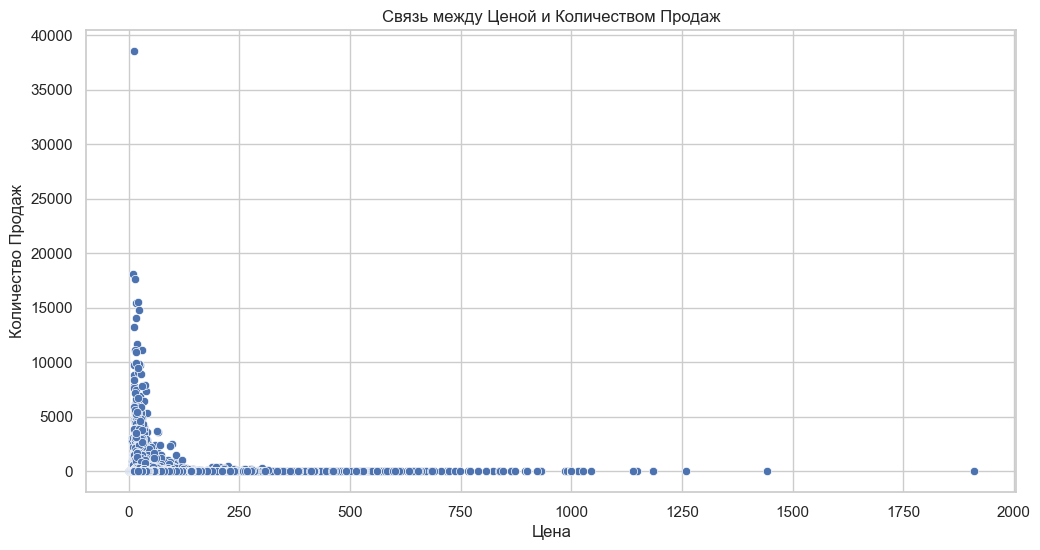

In [34]:
# Двумерный анализ цены и количества продаж
plt.figure(figsize=(12, 6))
sns.scatterplot(x='price', y='sales_qty', data=assortment_test)
plt.title('Связь между Ценой и Количеством Продаж')
plt.xlabel('Цена')
plt.ylabel('Количество Продаж')
plt.show()

 - На графике видно, что большинство товаров с высокими объемами продаж имеют относительно низкую цену. Это может указывать на то, что более доступные товары имеют тенденцию к более высоким продажам.
 - Существует несколько товаров с высокой ценой и относительно высоким количеством продаж, но это скорее исключения, чем общее правило.

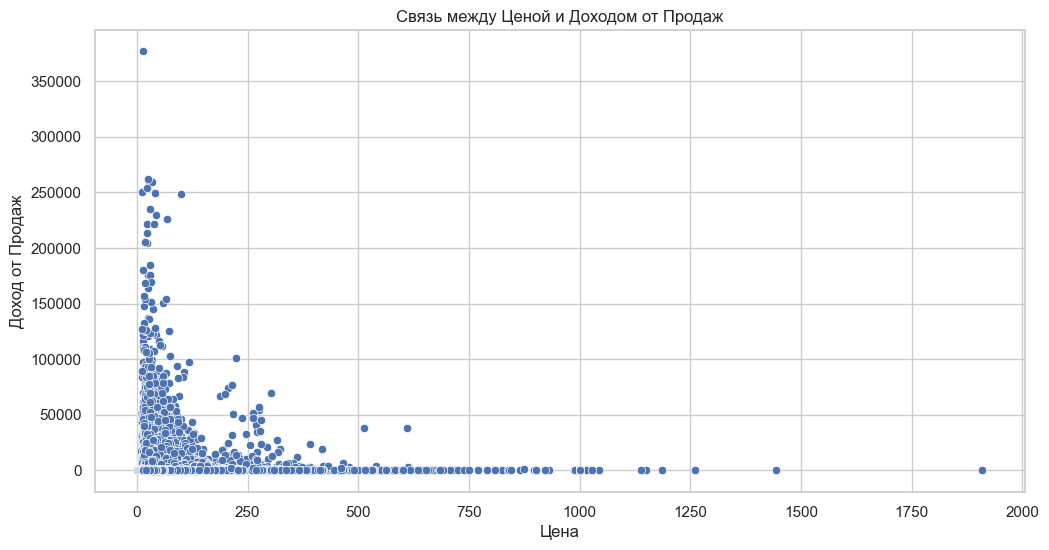

In [35]:
# Двумерный анализ цены и дохода от продаж
plt.figure(figsize=(12, 6))
sns.scatterplot(x='price', y='sales_revenue', data=assortment_test)
plt.title('Связь между Ценой и Доходом от Продаж')
plt.xlabel('Цена')
plt.ylabel('Доход от Продаж')
plt.show()

 - График показывает, что товары с низкой ценой могут генерировать значительный доход, вероятно, из-за высокого объема продаж.
 - Несмотря на некоторые исключения, высокая цена товара не всегда означает высокий доход от продаж. Многие дорогие товары имеют низкий доход от продаж.

### Boxplot

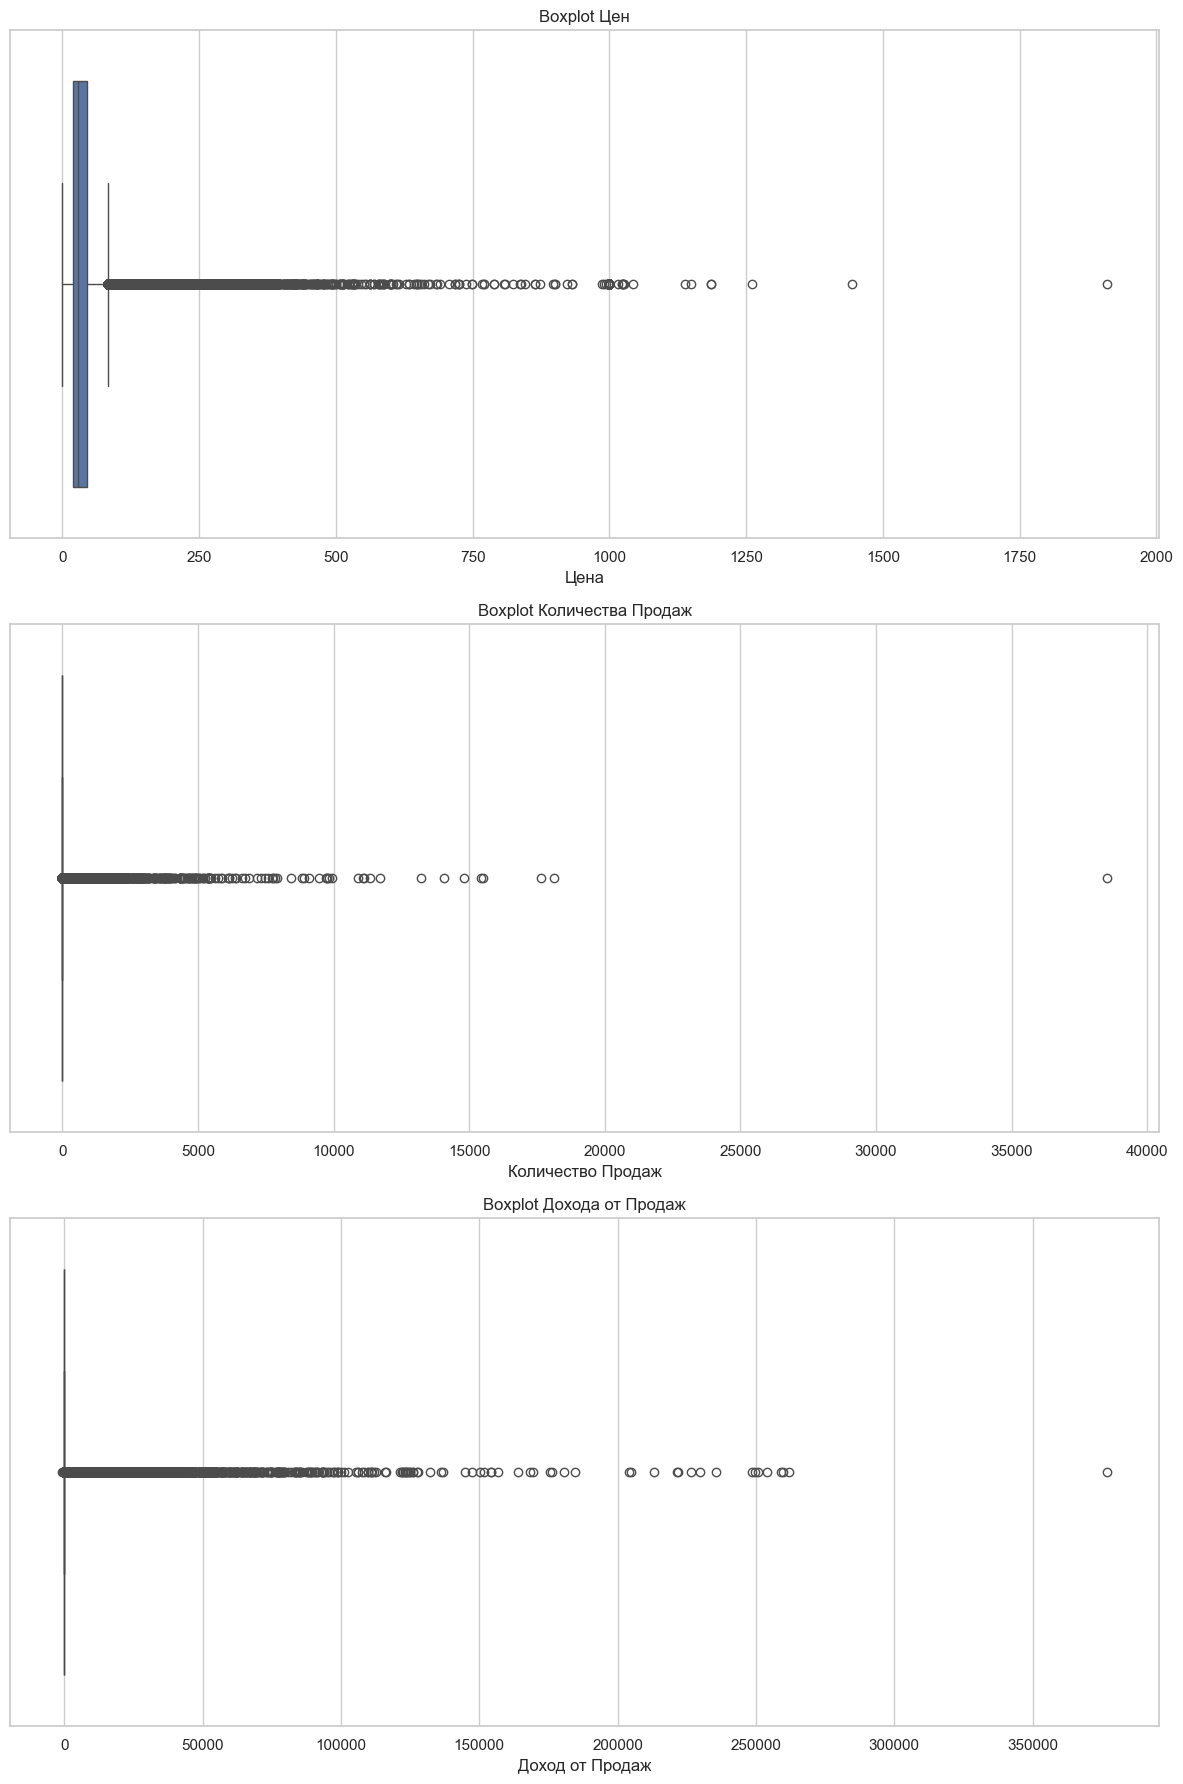

In [53]:
# Анализ выбросов для ключевых переменных
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Boxplot для цены
sns.boxplot(x=assortment_test['price'], ax=axes[0])
axes[0].set_title('Boxplot Цен')
axes[0].set_xlabel('Цена')

# Boxplot для количества продаж
sns.boxplot(x=assortment_test['sales_qty'], ax=axes[1])
axes[1].set_title('Boxplot Количества Продаж')
axes[1].set_xlabel('Количество Продаж')

# Boxplot для дохода от продаж
sns.boxplot(x=assortment_test['sales_revenue'], ax=axes[2])
axes[2].set_title('Boxplot Дохода от Продаж')
axes[2].set_xlabel('Доход от Продаж')

plt.tight_layout()
plt.show()


- **Цена**: Большинство цен сосредоточено в нижнем диапазоне, но имеются значительные выбросы с очень высокой ценой. Эти выбросы могут указывать на премиальные или специализированные товары.

- **Количество Продаж**: Аналогично, большая часть продаж сосредоточена на низких уровнях, но существуют выбросы с очень высокими объемами продаж. Это может указывать на наиболее популярные или востребованные товары.

- **Доход от Продаж**: Распределение дохода от продаж показывает схожую картину с распределением количества продаж, где большинство товаров приносят низкий доход, но есть выбросы с очень высоким доходом.

In [72]:
# Кодирование категориальных переменных
# Использование one-hot encoding для переменной category_name
category_encoded = pd.get_dummies(assortment_test['category_name'], prefix='category')

# Добавление закодированных столбцов обратно в исходный assortment_testFrame
assortment_test_encoded = assortment_test.join(category_encoded)

# Удаление оригинального столбца category_name, так как он уже закодирован
assortment_test_encoded.drop('category_name', axis=1, inplace=True)

assortment_test_encoded.drop('all_OEM_number', axis=1, inplace=True)

# Проверка результатов предварительной обработки
assortment_test_encoded.head()


,article_id,brand_number,price,sales_qty,sales_netto,sales_revenue,sales_count_country,category_Brake disc,category_Brake pad set
0,1,11385,37.85,1,23.120001,40.200001,1,False,True
1,2,11385,12.57,0,0.000000,0.000000,0,False,True
2,3,11385,8.86,3,15.659999,31.620000,2,False,True
3,4,11893,29.92,0,0.000000,0.000000,0,False,True
4,5,11893,20.66,2,24.880000,39.220001,2,False,True


In [73]:
# Выбор числовых колонок для стандартизации
numeric_columns = ['price', 'sales_qty', 'sales_netto', 'sales_revenue', 'sales_count_country']

# Инициализация стандартизатора
scaler = StandardScaler()

# Применение стандартизации к числовым колонкам
assortment_test_encoded[numeric_columns] = scaler.fit_transform(assortment_test_encoded[numeric_columns])

# Разделение данных на обучающую и тестовую выборки
# Здесь предполагается, что целевой переменной будет одна из переменных, связанных с продажами, например 'sales_qty'
X = assortment_test_encoded.drop(['sales_qty'], axis=1)
y = assortment_test_encoded['sales_qty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Проверка размеров полученных выборок
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


((215256, 8), (53815, 8), (215256,), (53815,))

    Обучающая выборка: 215,256 записей
    Тестовая выборка: 53,815 записей

# LinearRegression

In [78]:
# инициализация модели линейной регрессии
linear_reg = LinearRegression()

# обучение модели на обучающей выборке
linear_reg.fit(X_train, y_train)

# предсказание на тестовой выборке
y_pred = linear_reg.predict(X_test)

# вычисление метрик качества модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(0.11080276421068977, 0.885824952326662)

результаты:

    Среднеквадратичная ошибка (MSE): 0.11060.1106
    Коэффициент детерминации (R2R2): 0.88610.8861

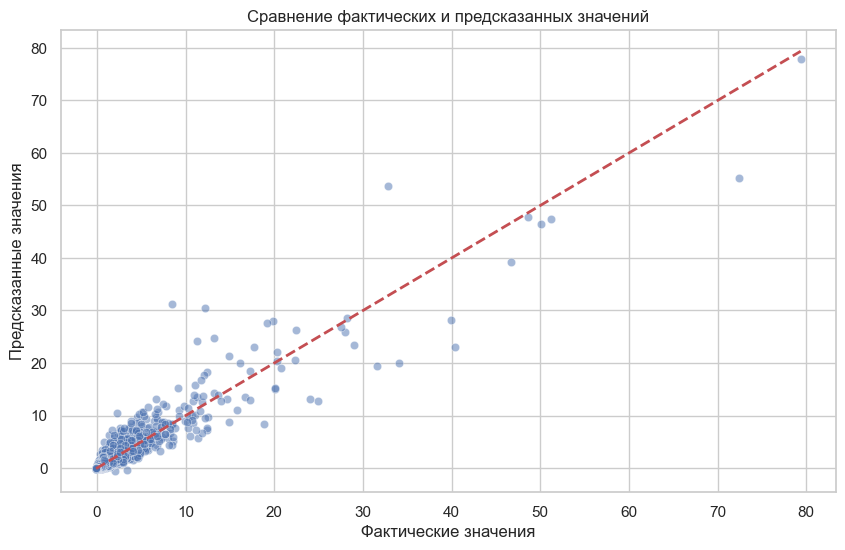

In [79]:
# Создание графика для сравнения фактических и предсказанных значений
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение фактических и предсказанных значений')
plt.show()

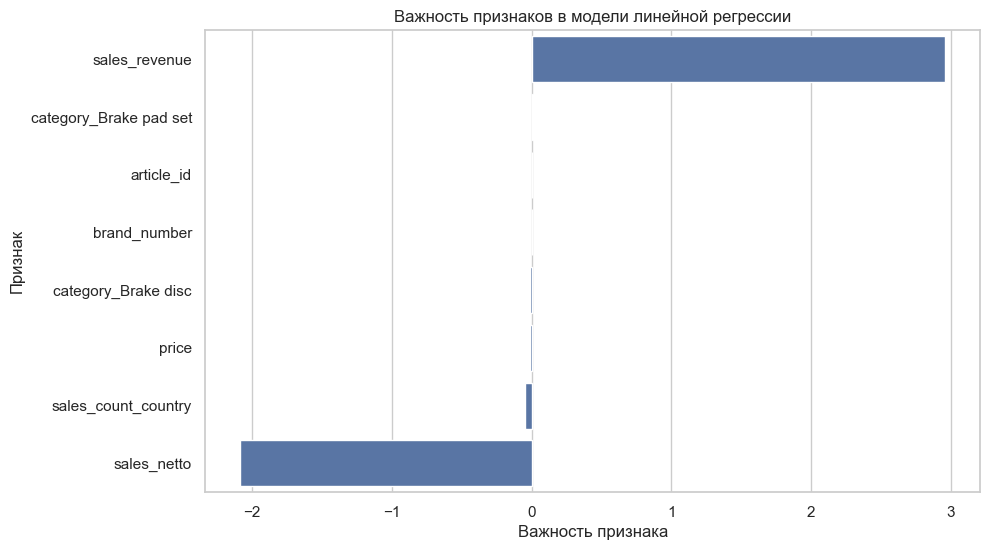

In [81]:
# Получение коэффициентов модели линейной регрессии
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': linear_reg.coef_
})

# Сортировка признаков по их важности
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Важность признаков в модели линейной регрессии')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.show()


 Положительные значения означают, что при увеличении данного признака предсказанное значение продаж также увеличивается, а отрицательные значения указывают на обратную зависимость. Величина коэффициента отражает степень влияния признака на результат.

# RandomForestRegressor

In [76]:
# инициализация модели случайного леса
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# обучение модели случайного леса на обучающей выборке
random_forest.fit(X_train, y_train)

# предсказание на тестовой выборке
y_pred_rf = random_forest.predict(X_test)

# вычисление метрик качества модели случайного леса
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_rf, r2_rf

(0.03558847605356094, 0.9633283882493181)

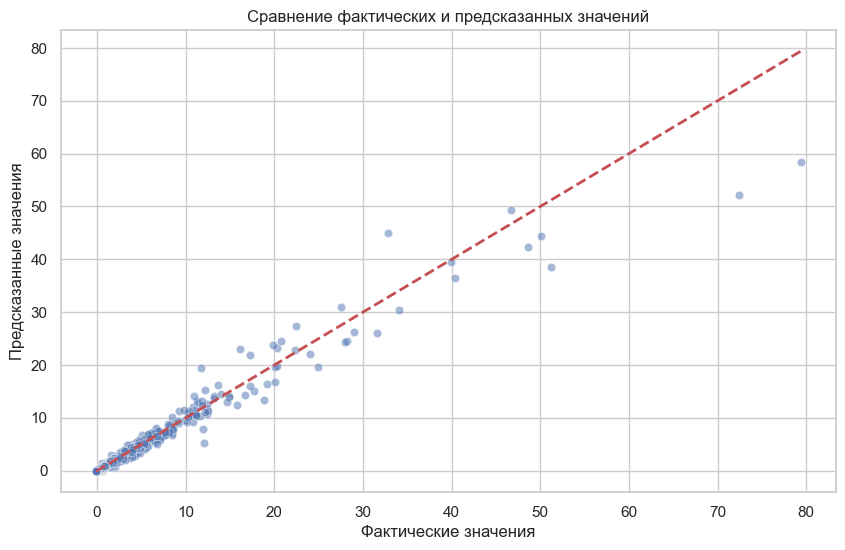

In [84]:
# Создание графика для сравнения фактических и предсказанных значений
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение фактических и предсказанных значений')
plt.show()

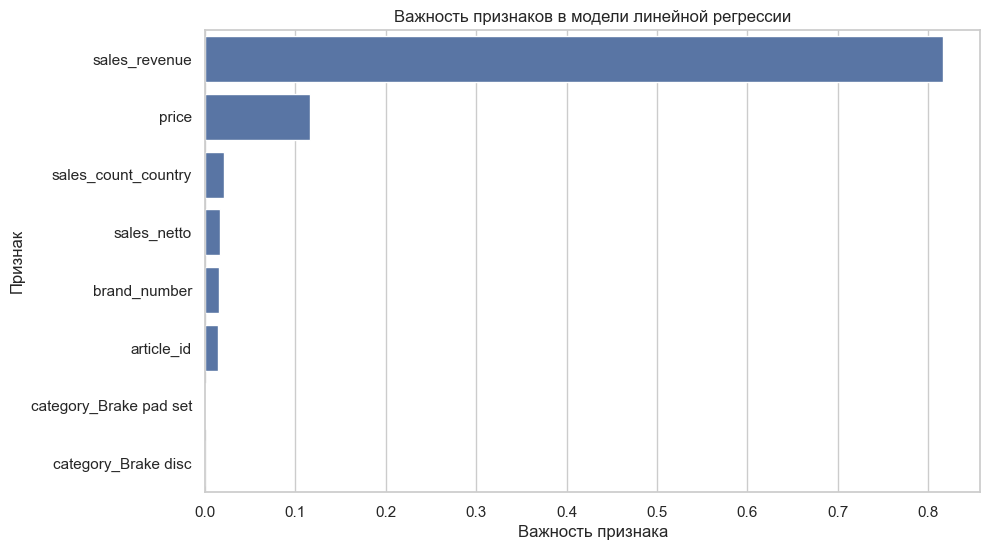

In [87]:
# Получение коэффициентов модели линейной регрессии
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': random_forest.feature_importances_
})

# Сортировка признаков по их важности
feature_importance_rf = feature_importance_rf.sort_values(by='importance', ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_rf)
plt.title('Важность признаков в модели линейной регрессии')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.show()


# cluster

In [104]:
assortment_test.loc[assortment_test['all_OEM_number'] == '0', 'all_OEM_number'] = ''

In [105]:
# Использование TF-IDF для преобразования OEM номеров в числовые векторы
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(','))
tfidf_matrix = tfidf_vectorizer.fit_transform(assortment_test['all_OEM_number'].fillna(''))

# Применение K-средних для кластеризации
# Количество кластеров выбирается произвольно, можно подобрать оптимальное количество кластеров позже
number_of_clusters = 5
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)

# Добавление меток кластеров к исходным данным
assortment_test['cluster'] = clusters

# Просмотр первых нескольких записей с метками кластеров
assortment_test.head()

C:\Users\Stunez\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Stunez\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,article_id,brand_number,category_name,price,sales_qty,sales_netto,sales_revenue,sales_count_country,all_OEM_number,cluster
0,1,11385,Brake pad set,37.85,1,23.120001,40.200001,1,"15920117, 15920396",2
1,2,11385,Brake pad set,12.57,0,0.000000,0.000000,0,935015,2
2,3,11385,Brake pad set,8.86,3,15.659999,31.620000,2,"47800849, 15920103, 3221003",2
3,4,11893,Brake pad set,29.92,0,0.000000,0.000000,0,"1614412180, 5P1902, 1612434180, 77366679",2
4,5,11893,Brake pad set,20.66,2,24.880000,39.220001,2,"4106000Q1L, 410605961R, 8660000781, 410601306R...",2


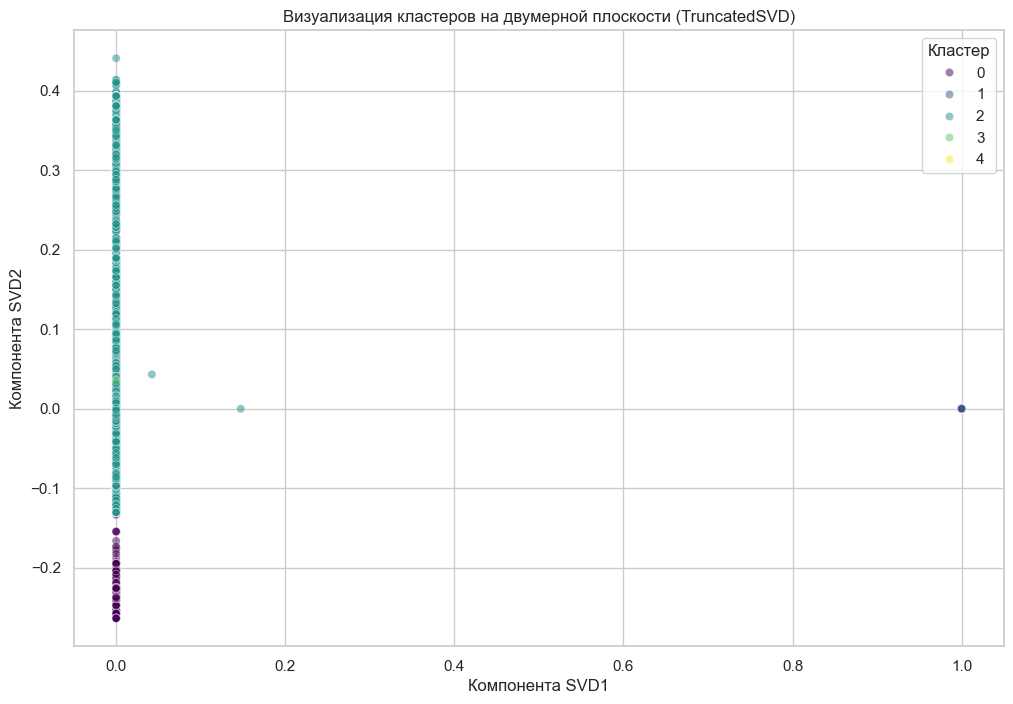

In [106]:
# Использование TruncatedSVD для сокращения размерности данных до 2D для визуализации кластеров
svd = TruncatedSVD(n_components=2)
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

# Создание DataFrame для визуализации результатов кластеризации
plot_data = pd.DataFrame(tfidf_matrix_reduced, columns=['SVD1', 'SVD2'])
plot_data['cluster'] = clusters

# Визуализация результатов кластеризации
plt.figure(figsize=(12, 8))
sns.scatterplot(x='SVD1', y='SVD2', hue='cluster', palette='viridis', data=plot_data, alpha=0.5)
plt.title('Визуализация кластеров на двумерной плоскости (TruncatedSVD)')
plt.xlabel('Компонента SVD1')
plt.ylabel('Компонента SVD2')
plt.legend(title='Кластер')
plt.show()

In [107]:
assortment_test['cluster'].value_counts()

cluster
2    246672
1     21689
3       427
0       170
4       113
Name: count, dtype: int64

##### Анализ распределения цен и объемов продаж внутри каждого кластера

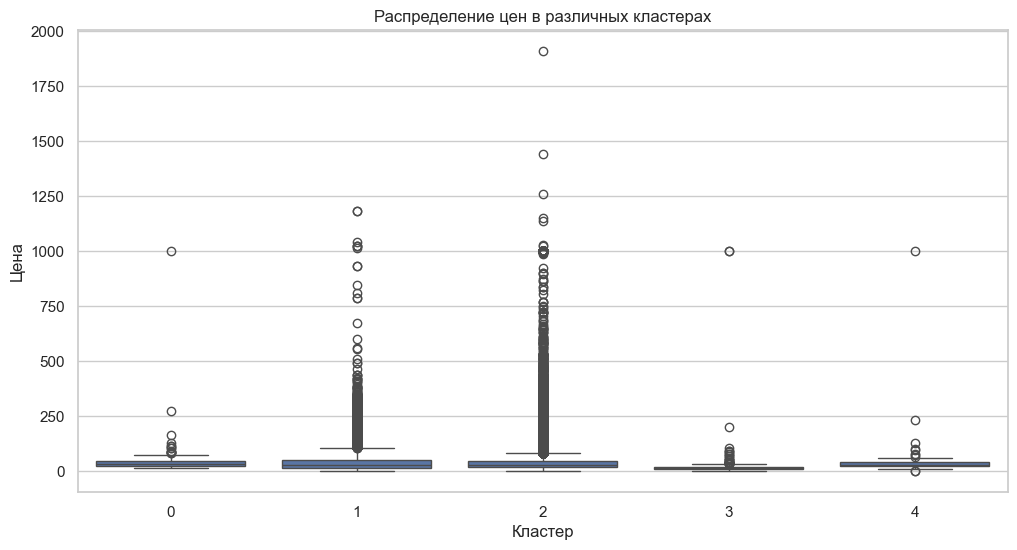

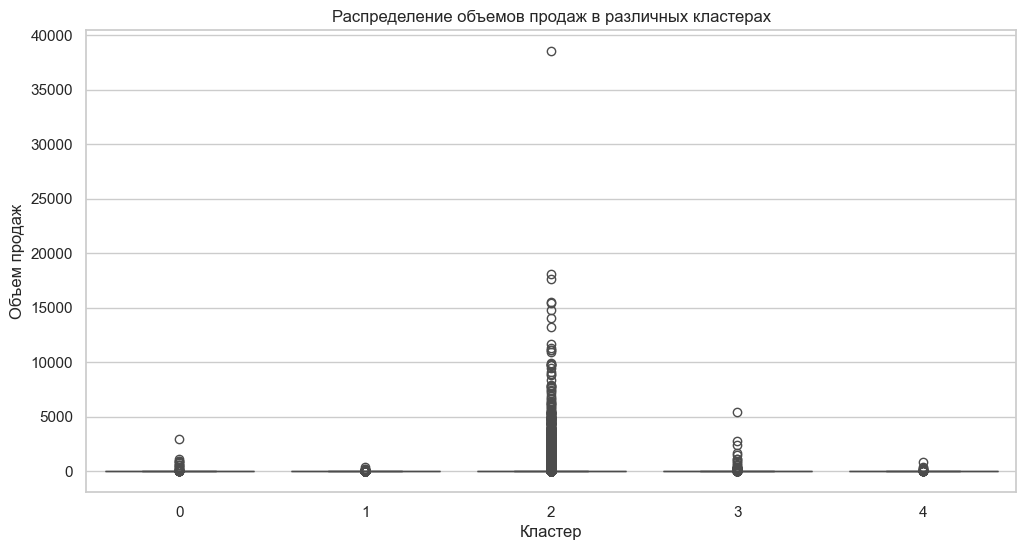

In [108]:
# Подготовка данных для анализа
clustered_data = assortment_test[['price', 'sales_qty', 'cluster']]

# Визуализация распределения цен в каждом кластере
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='price', data=clustered_data)
plt.title('Распределение цен в различных кластерах')
plt.xlabel('Кластер')
plt.ylabel('Цена')
plt.show()

# Визуализация распределения объемов продаж в каждом кластере
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='sales_qty', data=clustered_data)
plt.title('Распределение объемов продаж в различных кластерах')
plt.xlabel('Кластер')
plt.ylabel('Объем продаж')
plt.show()